In [21]:
# Loading neccesary packages:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#
from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

#
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

#
import warnings
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

#
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#
import pyodbc


In [22]:
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=Jaehyun\SQLEXPRESS;'
    r'DATABASE=EV_db;'
    r'Trusted_Connection=yes;'
)

df = pd.read_sql("SELECT * FROM ev.train", conn)
conn.close()

In [23]:
df.head()

,ID,Brand,Model,Car Condition,Battery Capacity,Driving System,Driving Distance,Warranty,Accident History,Old,Price
0,TRAIN_0000,P,TayGTS,Nearly New,86.077003,AWD,13642.0,0.0,No,2.0,159.660004
1,TRAIN_0001,K,Niro,Nearly New,56.000000,FWD,10199.0,6.0,No,0.0,28.010000
2,TRAIN_0002,A,eT,Brand New,91.199997,AWD,2361.0,7.0,No,0.0,66.269997
3,TRAIN_0003,A,RSeTGT,Nearly New,0.000000,AWD,21683.0,3.0,No,0.0,99.160004
4,TRAIN_0004,B,i5,Pre-Owned,61.018002,AWD,178205.0,1.0,No,0.0,62.020000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                7497 non-null   object 
 1   Brand             7497 non-null   object 
 2   Model             7497 non-null   object 
 3   Car Condition     7497 non-null   object 
 4   Battery Capacity  7497 non-null   float64
 5   Driving System    7497 non-null   object 
 6   Driving Distance  7497 non-null   float64
 7   Warranty          7497 non-null   float64
 8   Accident History  7497 non-null   object 
 9   Old               7497 non-null   float64
 10  Price             7497 non-null   float64
dtypes: float64(5), object(6)
memory usage: 644.4+ KB


In [ ]:
df.describe(include='all').T

,Battery Capacity
Missing Values,2711.000000
Percent,36.161131


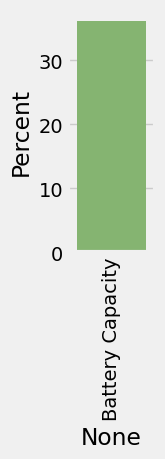

In [35]:
def missing_percentage(df):
    """Return total and percentage of missing values in a DataFrame."""
    return (
        df.isnull()
        .sum()
        .to_frame(name="Missing Values")
        .assign(Percent=lambda x: (x["Missing Values"] / len(df)) * 100)
        .query("`Missing Values` > 0")
        .sort_values("Missing Values", ascending=False)
    )
    
# Checking 'NaN' values.
missing = missing_percentage(df)

fig, ax = plt.subplots(figsize=(1, 3))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='summer')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='summer', axis=1))

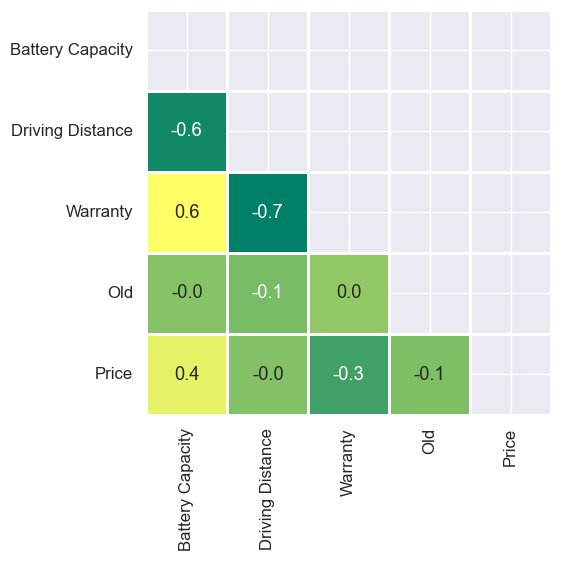

In [37]:
# Set the font scale for the heatmap
sns.set(font_scale=1.1)

# Calculate the correlation matrix for numerical features only
correlation_train = df.select_dtypes(include=['number']).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_train, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(5, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='summer',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

# Show the plot
plt.show()

### Dealing with missing values

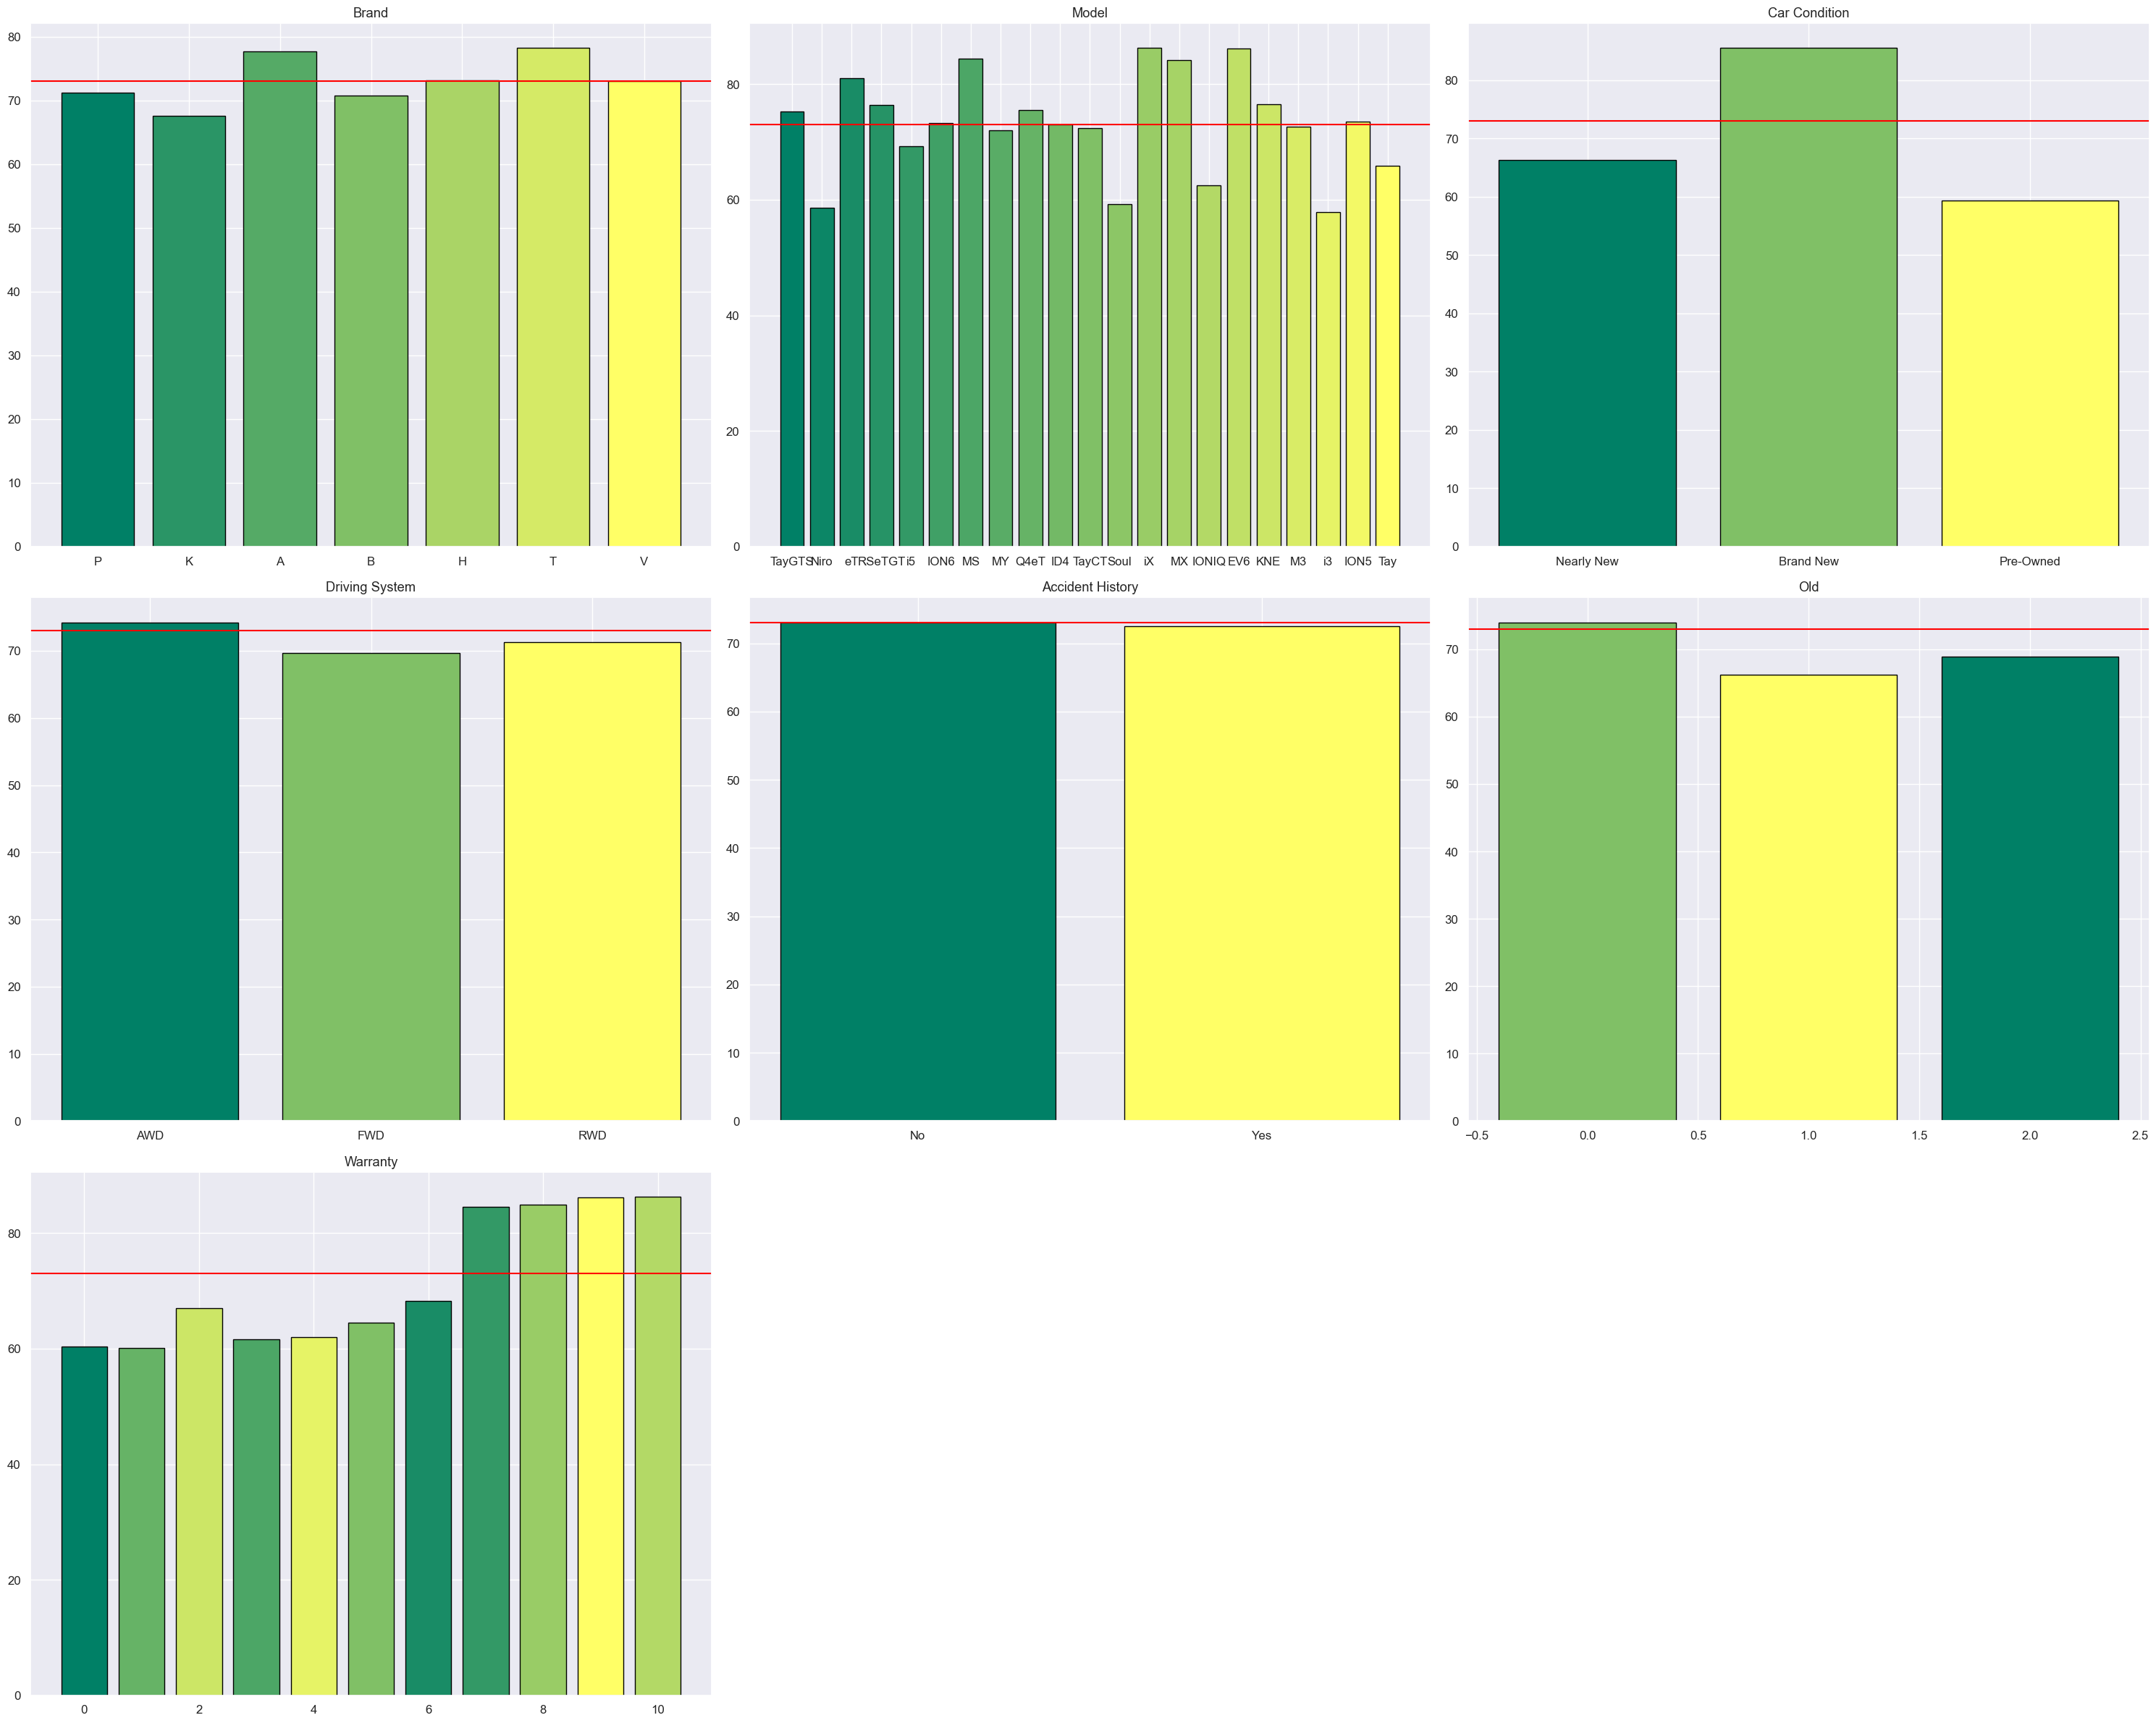

In [47]:
# Define the column keys
column_keys = ['Brand', 'Model', 'Car Condition', 'Driving System', 'Accident History', 'Old', 'Warranty']

# Create subplots with 3 visualizations in one row
fig, axes = plt.subplots(nrows=(len(column_keys) + 2) // 3, ncols=3, figsize=(30, 8 * ((len(column_keys) + 2) // 3)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column key and create a bar plot in a subplot
for idx, column_key in enumerate(column_keys):
    ax = axes[idx]
    unique_keys = df[column_key].unique().tolist()
    means = [df[df[column_key] == key]['Battery Capacity'].mean() for key in unique_keys]
    
    bars = ax.bar(unique_keys, 
                  means, 
                  color=plt.cm.summer(np.linspace(0, 1, len(unique_keys))),
                  edgecolor='black')
    ax.axhline(y=df['Battery Capacity'].mean(), color='red')
    
    ax.set_title(column_key)

# Remove any unused subplots
for idx in range(len(column_keys), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [42]:
# To deal with Battery Capacity
upper7 = df[df['Warranty']>=7]['Battery Capacity'].mean()
lower7 = df[df['Warranty']<7]['Battery Capacity'].mean()

df.fillna(-1, inplace=True)
def fill_battery(row):
    if row['Battery Capacity'] == -1:
        if row['Warranty'] >= 7:
            return upper7
        else:
            return lower7
    return row['Battery Capacity']

df['Battery Capacity'] = df.apply(fill_battery, axis=1)

In [43]:
df

,ID,Brand,Model,Car Condition,Battery Capacity,Driving System,Driving Distance,Warranty,Accident History,Old,Price
0,TRAIN_0000,P,TayGTS,Nearly New,86.077003,AWD,13642.0,0.0,No,2.0,159.660004
1,TRAIN_0001,K,Niro,Nearly New,56.000000,FWD,10199.0,6.0,No,0.0,28.010000
2,TRAIN_0002,A,eT,Brand New,91.199997,AWD,2361.0,7.0,No,0.0,66.269997
3,TRAIN_0003,A,RSeTGT,Nearly New,63.932581,AWD,21683.0,3.0,No,0.0,99.160004
4,TRAIN_0004,B,i5,Pre-Owned,61.018002,AWD,178205.0,1.0,No,0.0,62.020000
...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H,ION5,Brand New,85.282460,AWD,3773.0,10.0,No,0.0,35.950001
7493,TRAIN_7493,B,i3,Pre-Owned,46.000000,RWD,135411.0,2.0,No,0.0,23.400000
7494,TRAIN_7494,P,TayCT,Brand New,63.932581,AWD,1363.0,2.0,No,0.0,120.000000
7495,TRAIN_7495,B,i3,Nearly New,56.000000,RWD,39445.0,6.0,No,2.0,24.000000


### EDA

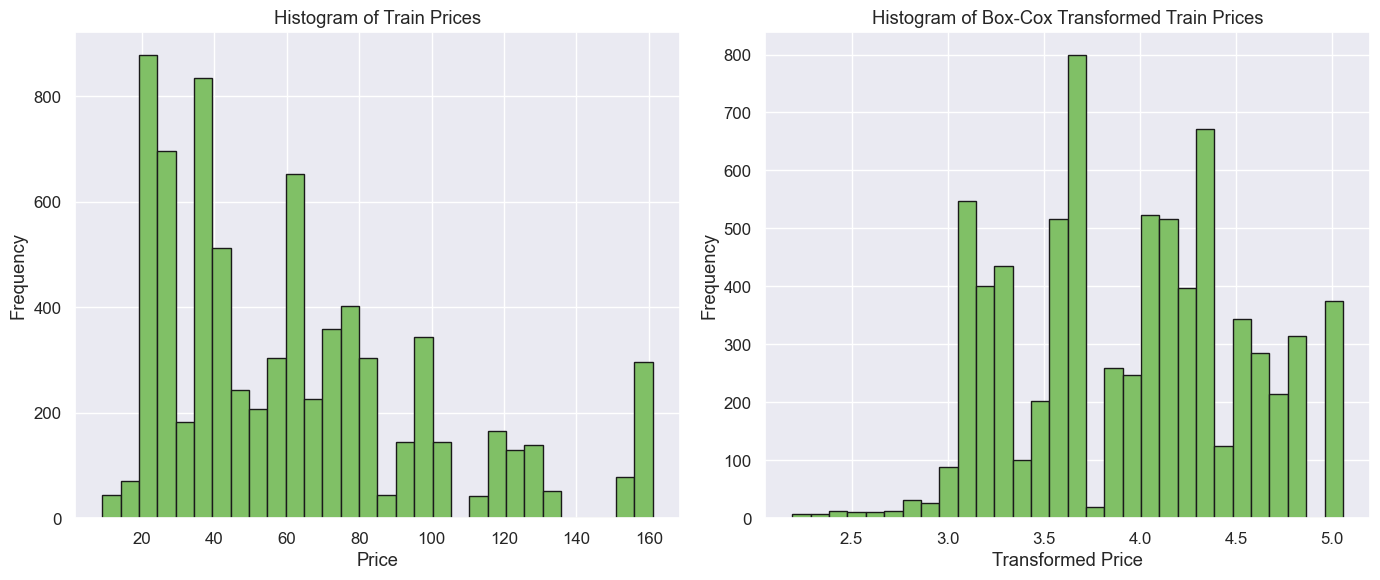

In [48]:
# Apply Box-Cox transformation
df['Price_BoxCox'], _ = stats.boxcox(df['Price'])

# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original Price Histogram
axes[0].hist(df['Price'], bins=30, edgecolor='k', color=plt.cm.summer(0.5))
axes[0].set_title('Histogram of Train Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Box-Cox Transformed Price Histogram
axes[1].hist(df['Price_BoxCox'], bins=30, edgecolor='k', color=plt.cm.summer(0.5))
axes[1].set_title('Histogram of Box-Cox Transformed Train Prices')
axes[1].set_xlabel('Transformed Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

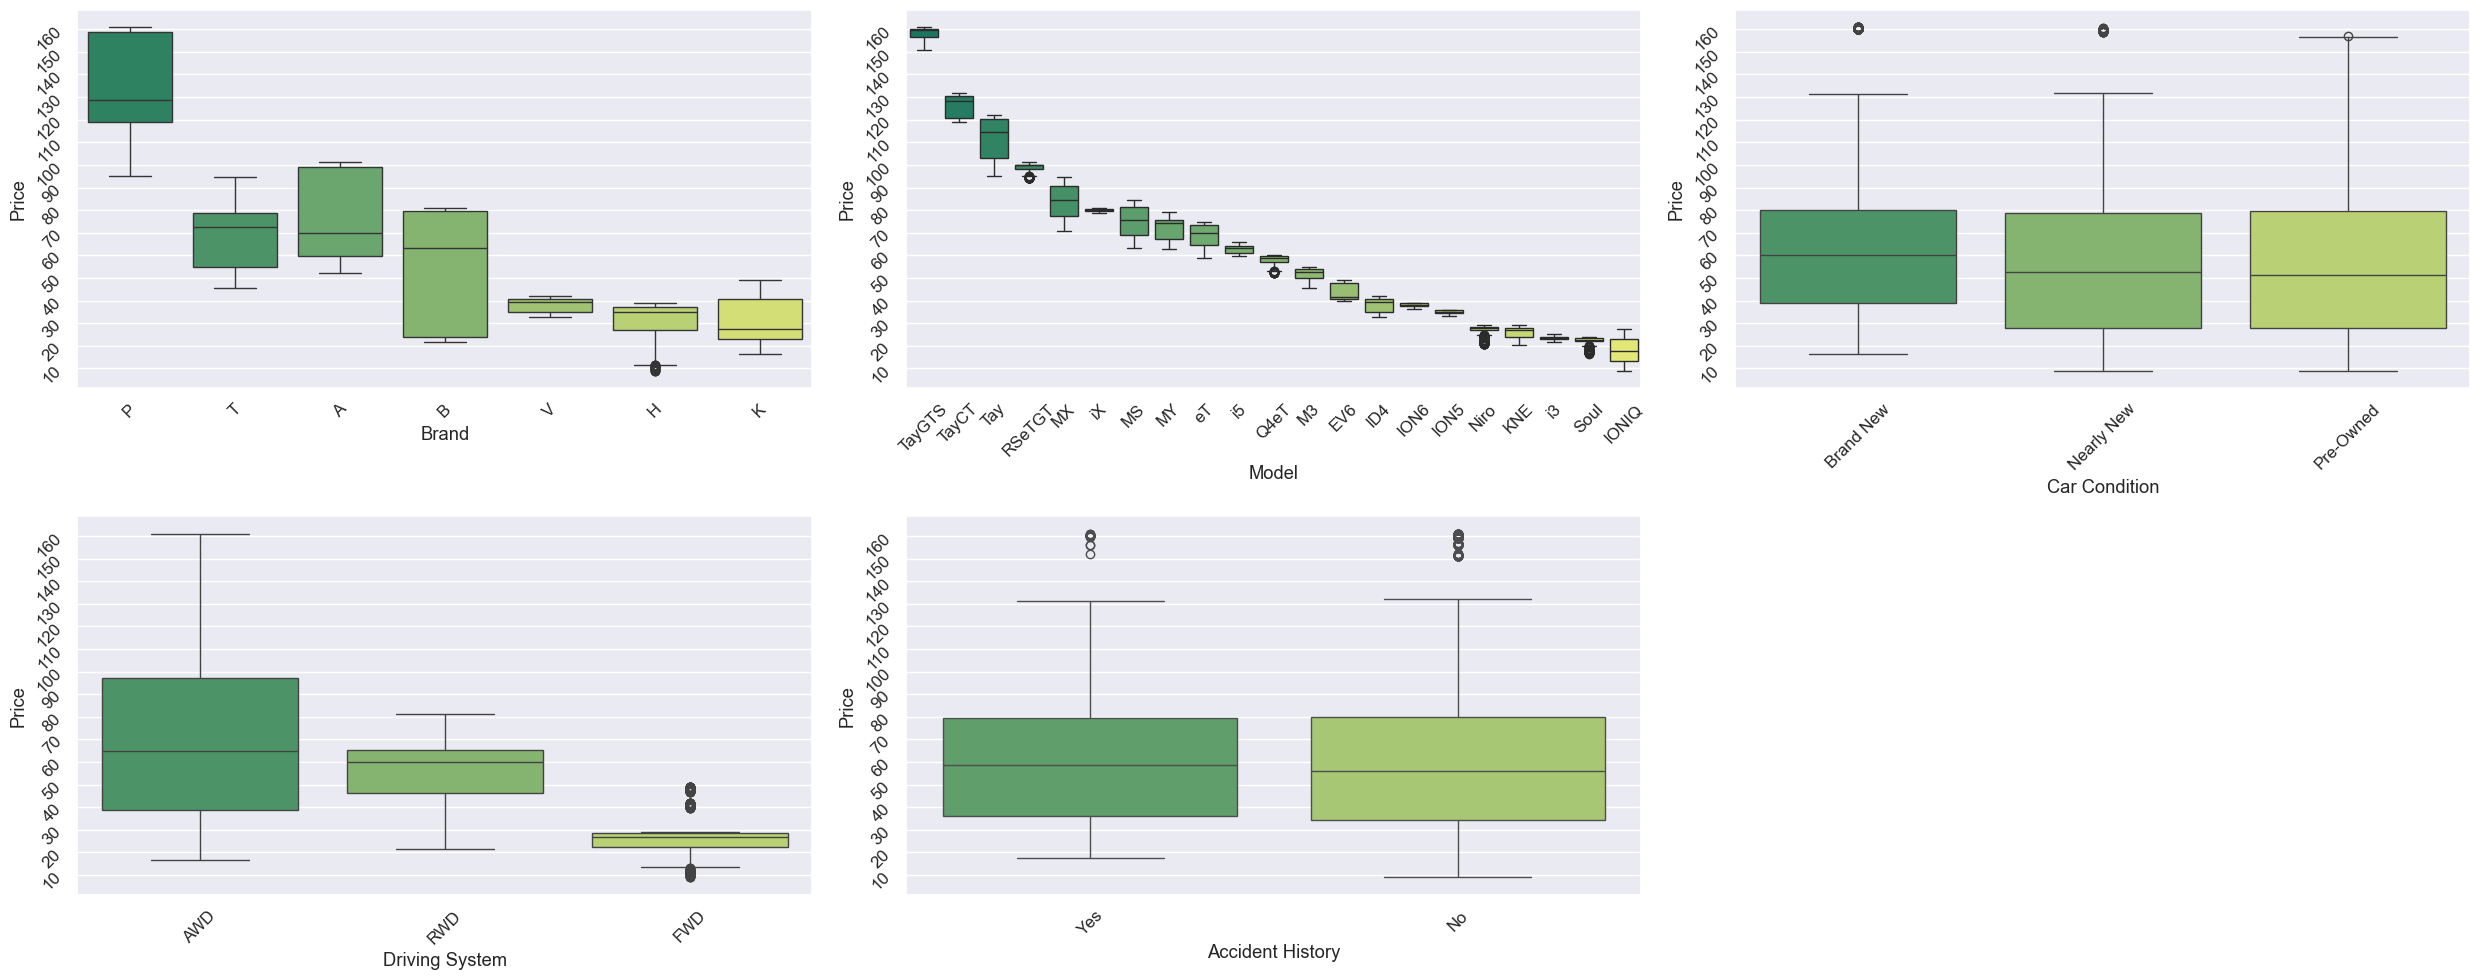

In [50]:
# For Categorical Variables
def srt_box(y, df):
    '''A function for displaying categorical variables.'''
    
    cat_features = df.select_dtypes(include=['object']).columns
    num_plots = len(cat_features)
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, 5 * rows))
    axes = axes.flatten()

    for i, (feature, ax) in enumerate(zip(cat_features, axes)):
        sortd = df.groupby([feature])[y].median().sort_values(ascending=False)
        sns.boxplot(x=feature,
                    y=y,
                    data=df,
                    palette='summer',
                    order=sortd.index,
                    ax=ax)
        ax.tick_params(labelrotation=45)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=18))

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

srt_box('Price', df.drop(columns=['ID'], errors='ignore'))

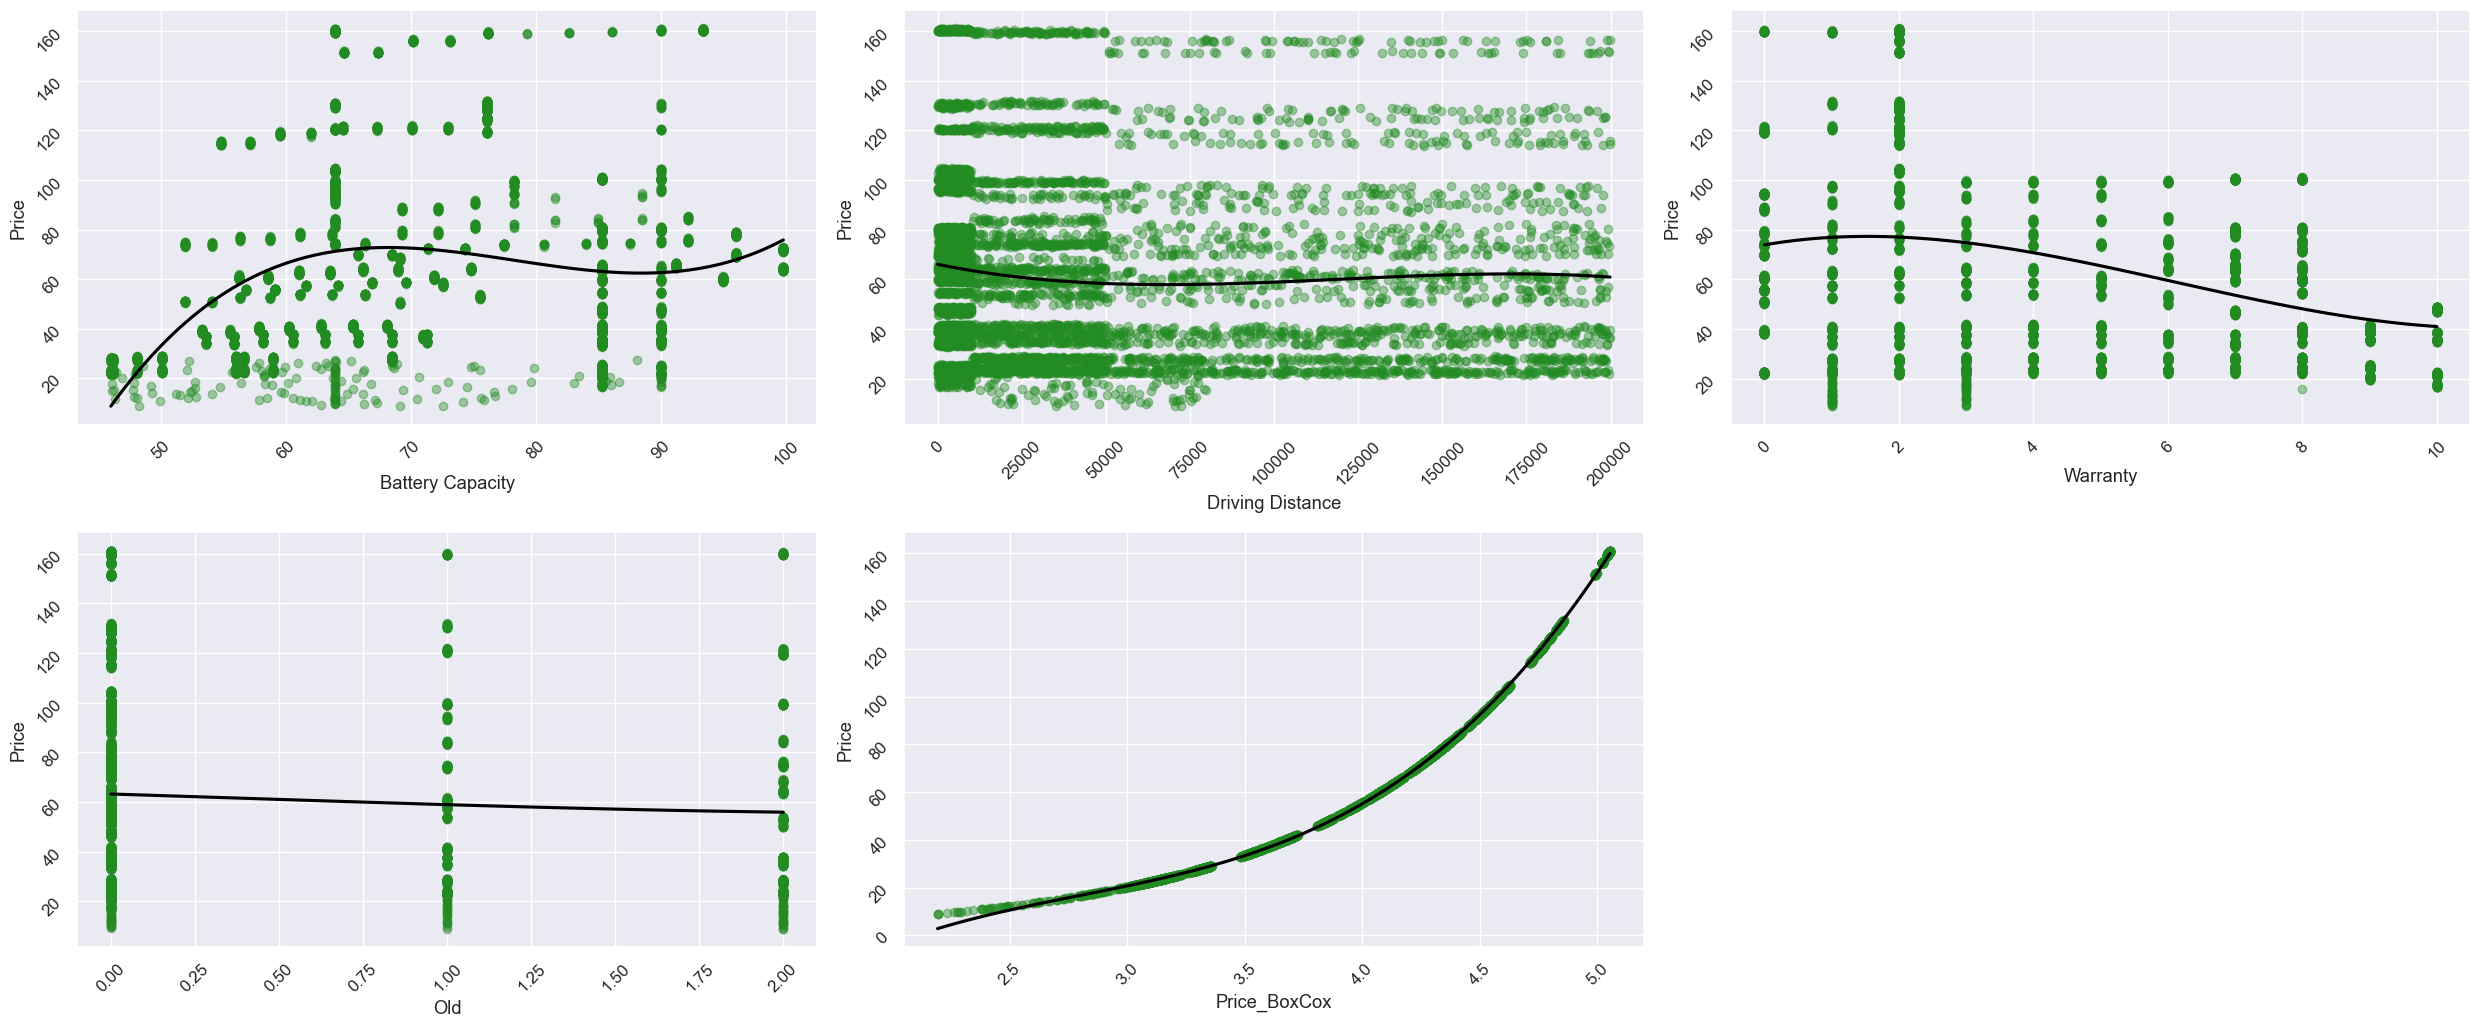

In [52]:
# For numerical varaibles
def srt_reg(y, df):
    num_features = df.select_dtypes(include=['number']).columns.drop(y)
    num_plots = len(num_features)
    rows = (num_plots // 2) + (num_plots % 2 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, 5 * rows))
    axes = axes.flatten()

    for i, (feature, ax) in enumerate(zip(num_features, axes)):
        sns.regplot(x=feature,
                    y=y,
                    data=df,
                    ax=ax,
                    order=3,
                    ci=None,
                    color='forestgreen',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha': 0.4})
        ax.tick_params(labelrotation=45)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

# Example usage:
srt_reg('Price', df)